In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from seaborn import heatmap

In [152]:
CLFS_SET = [
    ["bert", "temperature_scaling"],
    ["xlnet", "temperature_scaling"],
    ["ktmk", "isotonic"],
    ["ktr", "isotonic"],
    ["lstmk", "isotonic"],
    ["lstr", "isotonic"],
    ["ltr", "isotonic"]
]
CLFS_SET.sort(key=lambda x: x[0])

FEATURES_SET = [
    "centroids-ratios",
    "dist-20",
    "neigborhood",
    "probas",
    "probas-based",
    "bert"
]

FEATURES_SET.sort()
STACKING_DIR = "/home/welton/data/stacking/stacking_output"
meta_layer = "logistic_regression/best_clf"

idx_to_clf = {idx: clf for idx, (clf, _) in enumerate(CLFS_SET)}


In [153]:
clf_sufix = '/'.join([ f"{c[0]}_{c[1]}" for c in CLFS_SET ])
mf_sufix = '_'.join(FEATURES_SET)

clf_sufix, mf_sufix


('bert_temperature_scaling/ktmk_isotonic/ktr_isotonic/lstmk_isotonic/lstr_isotonic/ltr_isotonic/xlnet_temperature_scaling',
 'bert_centroids-ratios_dist-20_neigborhood_probas_probas-based')

In [154]:
DATASETS = [["acm", 10], ["20ng", 10]]

In [157]:
estimations = {}
for dataset, n_folds in DATASETS:
    
    estimations[dataset] = {
        "upper_test": [],
        "upper_train": [],
        "best_est": [],
        "y_test": [],
        "y_pred": [],
        "y_train": [],
        "missed_train": [],
        "missed_test": [],
        "multi_best_clf_est": []
    }

    for fold in np.arange(n_folds):
        loader = np.load(f"{STACKING_DIR}/{dataset}/{n_folds}_folds/{meta_layer}/{clf_sufix}/{mf_sufix}/fold_{fold}/output.npz")
        estimations[dataset]["upper_test"].append(loader["upper_test"])
        estimations[dataset]["upper_train"].append(loader["upper_train"])
        estimations[dataset]["best_est"].append(loader["best_est"])
        estimations[dataset]["y_train"].append(loader["y_train"])
        estimations[dataset]["y_test"].append(loader["y_test"])
        estimations[dataset]["y_pred"].append(loader["y_pred"])
        estimations[dataset]["missed_train"].append(loader["missed_train"])
        estimations[dataset]["missed_test"].append(loader["missed_test"])
        if meta_layer.find("multi_output") > -1:
            estimations[dataset]["multi_best_clf_est"].append(loader["multi_best_clf_est"])


# Taking the Classifier Selection Macro

In [145]:
list(estimations[DATASETS[0][0]].keys())

['upper_test',
 'best_est',
 'y_test',
 'y_pred',
 'y_train',
 'missed_train',
 'missed_test',
 'multi_best_clf_est']

In [146]:

for dataset in estimations:
    macro = 0
    macro_pos_label = 0
    for fold in np.arange(n_folds):
        if meta_layer.find("multi_output") == -1:
            m = f1_score(estimations[dataset]["upper_test"][fold], estimations[dataset]["best_est"][fold], average="macro")
            print(m)
            macro += m / n_folds
        else:
            n_classes = estimations[dataset]["upper_test"][fold].shape[1]
            class_macro = 0
            class_preds = []
            for c in np.arange(n_classes):
                class_preds.append(estimations[dataset]["multi_best_clf_est"][fold][c].argmax(axis=1))
            class_preds = np.vstack(class_preds).T
            
            class_macro = f1_score(estimations[dataset]["upper_test"][fold], class_preds, average="macro")
            macro += class_macro / n_folds

            p_macro = []
            for c in np.arange(n_classes):
                p_macro.append(f1_score(estimations[dataset]["upper_test"][fold][:, [c]], 
                                   class_preds[:, [c]], average="binary",
                                   pos_label=0))

            macro_pos_label += np.mean(p_macro) / 10

    print(f"{dataset.upper()}/{meta_layer} - {macro * 100} | {mf_sufix}")
    print(f"{dataset.upper()}/{meta_layer} - {macro_pos_label * 100} | {mf_sufix}")

0.2890742046261296
0.2684711483238707
0.27284935962934087
0.21926801898464207
0.2983915286579764
0.24323270506169603
0.21216888078198406
0.2392823822663263
0.2453870119852177
0.2931831322756467
ACM/logistic_regression/best_clf - 25.813083725928305 | probas-based
ACM/logistic_regression/best_clf - 0 | probas-based
0.313329708673125
0.23151161647793375
0.28518523054533856
0.28880998576393313
0.26631875557211754
0.21943878745967899
0.25337168085091344
0.245946162297326
0.2993426081524085
0.28432230811368214
20NG/logistic_regression/best_clf - 26.87576843906457 | probas-based
20NG/logistic_regression/best_clf - 0 | probas-based


# Taking the Classification Macro

In [147]:
for dataset in estimations:
    macro = 0
    for fold in np.arange(n_folds):
        m = f1_score(estimations[dataset]["y_test"][fold], estimations[dataset]["y_pred"][fold], average="macro")
        print(m)
        macro += m / n_folds
    print(f"{dataset.upper()}/{meta_layer} - {macro * 100} | {mf_sufix}")

0.7081717208227781
0.7140766908243737
0.6707218505272972
0.7405789704546162
0.6830477962893929
0.6921977188681832
0.7250869341044606
0.7084857036673461
0.7239023291454666
0.7219419618766572
ACM/logistic_regression/best_clf - 70.88211676580572 | probas-based
0.9332803886965524
0.9042511439592168
0.9207572481525463
0.9209575993774661
0.9188846387926104
0.9307975394968361
0.9178193582885129
0.9157627432226383
0.9256346176090557
0.9200011878526592
20NG/logistic_regression/best_clf - 92.08146465448094 | probas-based


# Classifiers Distribuition.

In [163]:
def expand_list(clf_counts: np.ndarray) -> list:

    final_list = []
    for idx, num in enumerate(clf_counts):
        final_list.extend(num * [idx])
    return final_list

def plot_skewness(CLFS_SET: list,
                  labels: np.ndarray,
                  preds: np.ndarray,
                  plot_idx: int):

    x = np.array([ i for i in np.arange(len(CLFS_SET)) ])

    plt.subplot(1, 2, plot_idx + 1)
    counts = pd.Series(labels).value_counts()
    keys = list(counts.keys())
    keys.sort()
    values = [ counts[key] if key in counts else 0 for key in x ]
    plt.bar(keys, values, label='Labels', color='blue', width=0.3)

    counts = pd.Series(preds).value_counts()
    keys = list(counts.keys())
    keys.sort()
    values = [ counts[key] if key in counts else 0 for key in x ]
    plt.bar(x+0.3, values, label='Predictions', color='red', alpha=0.5, width=0.3)
    plt.legend(fontsize=16)

    xtick_labels = [ idx_to_clf[idx] for idx in keys ]
    _ = plt.xticks(keys, xtick_labels, fontsize=16)
    _ = plt.yticks(fontsize=16)
    _ = plt.title(f"{dataset.upper()}", fontsize=16)
    _ = plt.xlabel("Classifiers", fontsize=16)
    _ = plt.ylabel("Num. Docs.", fontsize=16)

def plot_skewness_train(CLFS_SET: list, labels: np.ndarray, plot_idx: int, title: str):

    x = np.array([ i for i in np.arange(len(CLFS_SET)) ])

    plt.subplot(2, 4, plot_idx + 1)
    counts = pd.Series(labels).value_counts()
    keys = list(counts.keys())
    keys.sort()
    values = [ counts[key] if key in counts else 0 for key in x ]
    plt.bar(keys, values, label='Labels', color='blue', width=0.3)

    xtick_labels = [ idx_to_clf[idx] for idx in keys ]
    _ = plt.xticks(keys, xtick_labels, fontsize=16)
    _ = plt.yticks(fontsize=16)
    _ = plt.title(title, fontsize=16)
    _ = plt.xlabel("Classifiers", fontsize=16)
    _ = plt.ylabel("Num. Docs.", fontsize=16)

## On Test

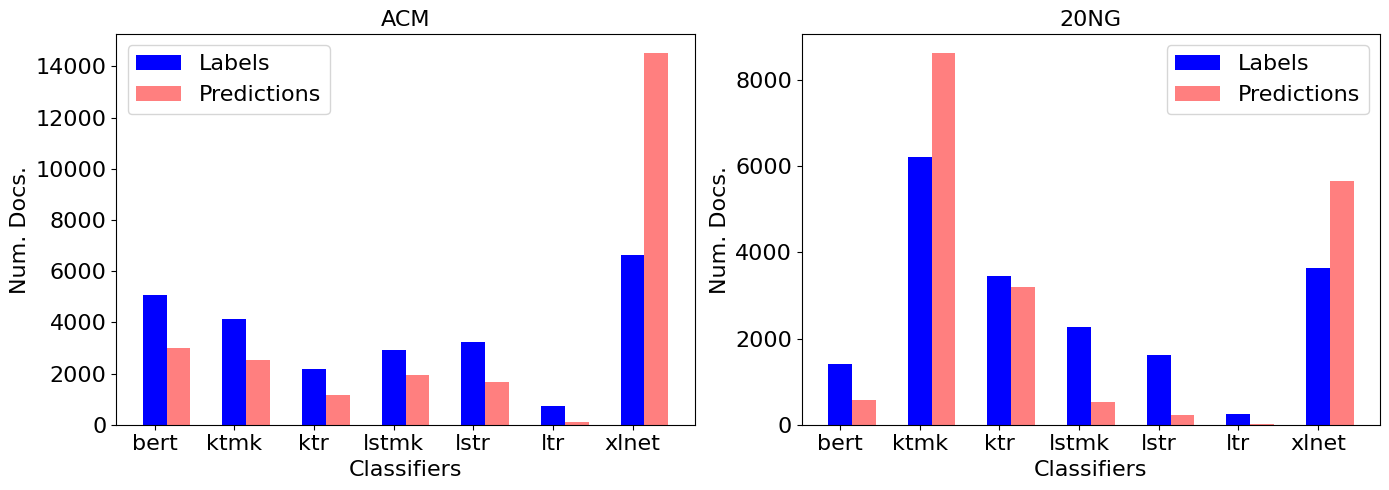

In [149]:
plt.figure(figsize=(14,5))
for plot_idx, dataset in enumerate(estimations):

    preds = []
    labels = []
    for fold in np.arange(n_folds):
        if meta_layer.find("multi_output") > -1:
            clf_counts = np.sum(estimations[dataset]["upper_test"][fold], axis=0)
            labels.append(expand_list(clf_counts))
            clf_counts = np.sum(np.vstack([ col.argmax(axis=1) for col in estimations[dataset]["multi_best_clf_est"][fold] ]).T, axis=0)
            preds.append(expand_list(clf_counts))
            
        else:
            labels.append(estimations[dataset]["upper_test"][fold])
            preds.append(estimations[dataset]["best_est"][fold])

    labels = np.hstack(labels)
    preds = np.hstack(preds)

    plot_skewness(CLFS_SET, labels, preds, plot_idx)
plt.tight_layout()


## On Train

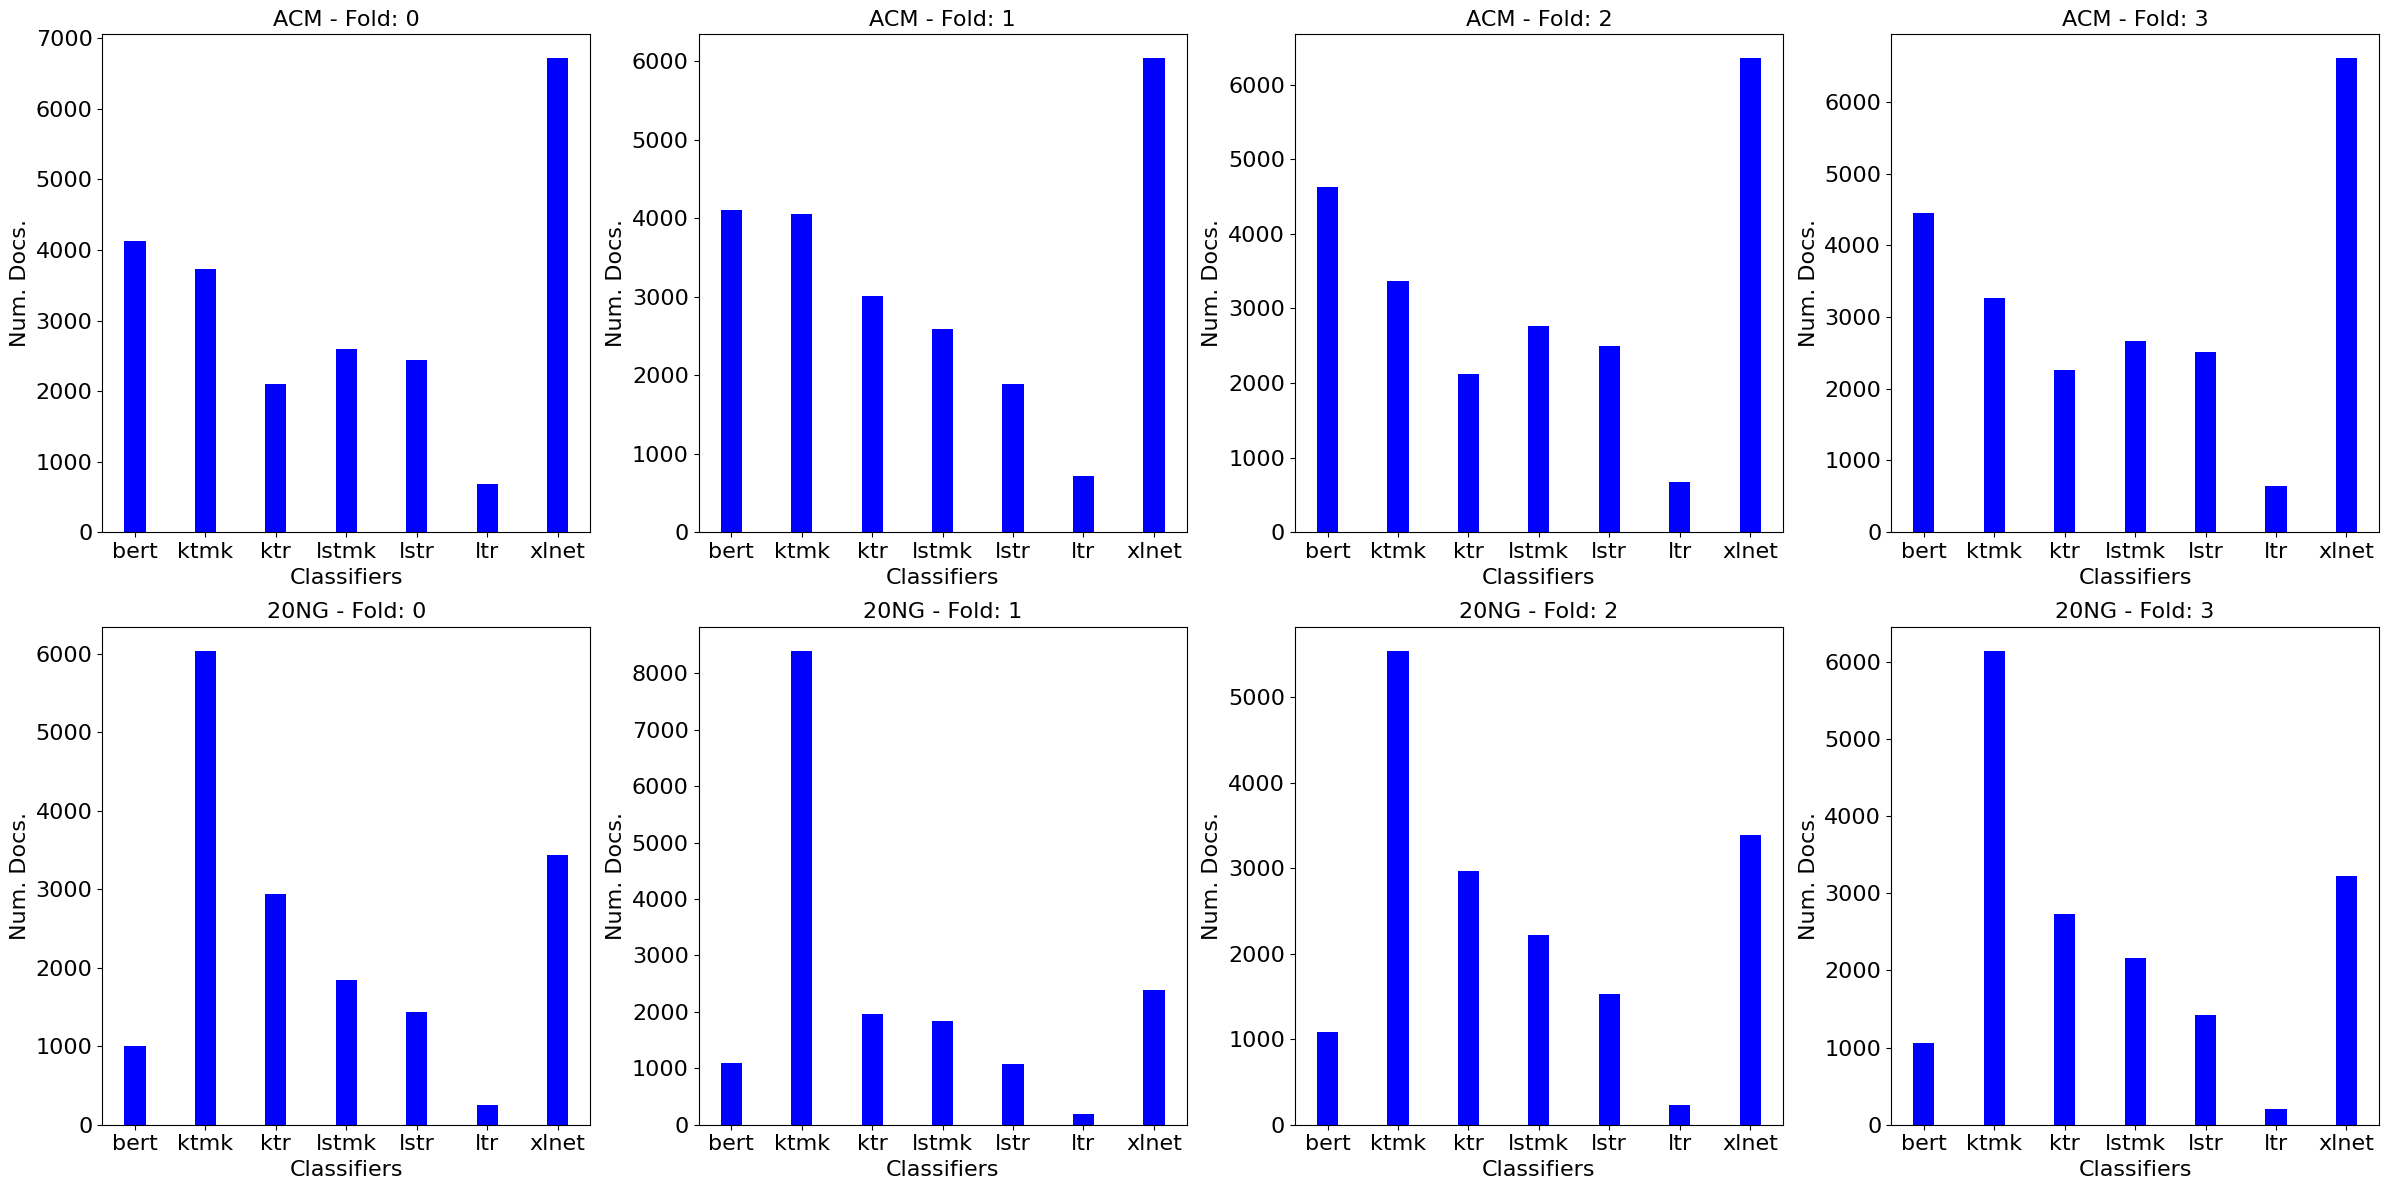

In [165]:
plt.figure(figsize=(24,12))
plot_idx = 0
for dataset in estimations:

    for fold in np.arange(4):
        if meta_layer.find("multi_output") > -1:
            clf_counts = np.sum(estimations[dataset]["upper_train"][fold], axis=0)
            plot_skewness_train(CLFS_SET, expand_list(clf_counts), plot_idx)
        else:
            plot_skewness_train(CLFS_SET, estimations[dataset]["upper_train"][fold], plot_idx, f"{dataset.upper()} - Fold: {fold}")
        plot_idx += 1
plt.tight_layout()

# Confusion Matrix

In [232]:
xtick_labels = [ idx_to_clf[idx] for idx in x ]

In [233]:
plt.figure(figsize=(14, 5))
for plot_idx, dataset in enumerate(estimations):
    preds = []
    labels = []
    for fold in np.arange(n_folds):
        labels.append(estimations[dataset]["upper_test"][fold])
        preds.append(estimations[dataset]["best_est"][fold])

    labels = np.hstack(labels)
    preds = np.hstack(preds)
    plt.subplot(1, 2, plot_idx + 1)
    cm = confusion_matrix(labels, preds, normalize='true')
    heatmap(cm, xticklabels=xtick_labels, yticklabels=xtick_labels, annot=True)
    plt.title(dataset.upper())
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2495 and the array at index 1 has size 2494

<Figure size 1400x500 with 0 Axes>